## 'Machine Learning and Statistics' module project, ATU<br>Semester 2, 2022<br>Lecturer: Ian McLoughlin

## Task: Time Series Anomaly detection using Keras

## Contents

1. [Introduction](#Introduction)<br>
2. [What is a Time Series?](#What-is-a-Time-Series?)<br>
3. [Analysis of Time Series](#Analysis-of-Time-Series)<br>
4. [What is anomaly detection?](#What-is-anomaly-detection?)<br>


5. [Types of time series anomalies](#Types-of-time-series-anomalies)<br>
    a. [Point anomalies (global outliers)](#Point-anomalies-(global-outliers))<br>
    b. [Collective-anomalies](#Collective-anomalies)<br>
    c. [Contextual anomalies](#Contextual-anomalies)<br>


6. [Terminology](#Terminology)<br>
    a. [Deep Learning](#Deep-Learning)<br>
    b. [Artificial neural networks](#Artificial-neural-networks)<br>
    c. [Loss](#Loss)<br>
    d. [Training loss](#Training-loss)<br>
    e. [Validation-loss](#Validation-loss)<br>
    f. [Mean Absolute Error (MAE)](#Mean-Absolute-Error-(MAE))<br>


7. [Keras vs Tensorflow](#Keras-vs-Tensorflow)<br>
    a. [When to use which tool](#When-to-use-which-tool)<br>
    b. [Tensorflow](#Tensorflow)<br>
    c. [Keras](#Keras)<br>


8. [Project setup](#Project-setup)<br>


9. [Autoencoder definition](#Autoencoder-definition)<br>
    a. [Use cases](#Use-cases)<br>
    b. [Advantages of autoencoders](#Advantages-of-autoencoders)<br>
    c. [Disadvantages of autoencoders](#Disadvantages-of-autoencoders)<br>


10. [First steps](#First-steps)<br>


11. [Visualise the data](#Visualise-the-data)<br>
    i. [Timeseries data without anomalies](#Timeseries-data-without-anomalies)<br>
    ii.[Timeseries data with anomalies](#Timeseries-data-with-anomalies)<br>


12. [Prepare the training data](#Prepare-the-training-data)<br>
    a. [Preprocessing](#Preprocessing)<br>
    b. [Mean and standard deviation](#Mean-and-standard-deviation)<br>
    c. [Add preprocessed data to dataframe](#Add-preprocessed-data-to-dataframe)<br>
    d. [Plot normalised training value](#Plot-normalised-training-value)<br>
    e. [Plot training data vs normalised data](#Plot-training-data-vs-normalised-data)<br>


13. [Create sequences](#Create-sequences)<br>
    a. [Example of window size](#Example-of-window-size)<br>
    b. [Number of windows needed](#Number-of-windows-needed)<br>
    c. [The Keras website example](#The-Keras-website-example)<br>
    d. [Superimposing the window on top of the data](#Superimposing-the-window-on-top-of-the-data)<br>


14. [Neural network](#Neural-network)<br>
    a. [Build a model](#Build-a-model)<br>
    b. [Code Explanation](#Code-Explanation)<br>
    c. [Convolution and convolutional/deconvolutional layers](#Convolution-and-convolutional/deconvolutional-layers)<br>
    d. [The sequential model](#The-sequential-model)<br>
    e. [Model Compilation](#Model-Compilation)<br>


15. [Code for the Sequential model](#Code-for-the-Sequential-model)<br>
    a. [Model weights](#Model-weights)<br>


16. [Train the model](#Train-the-model)<br>
    a. [Epoch Definition](#Epoch-Definition)<br>
    b. [Training and validation loss](#Training-and-validation-loss)<br>
    c. [Second model](#Second-model)<br>
    d. [Third model](#Third-model)<br>
    e. [Losses compared](#Losses-compared)<br>


17. [Anomaly detection](#Anomaly-detection)<br>
    a. [Compare reconstructed data with training data](#Compare-reconstructed-data-with-training-data)<br>
    b. [Prepare test data for the model](#Prepare-test-data-for-the-model)<br>


18. [Plot anomalies](#Plot-anomalies)<br>


19. [Conclusion](#Conclusion)<br>


20. [References](#)<br>

## Introduction
From the Keras website, use the example [Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/).<br>
<br>
Re-create the example and explain the concepts in more detail.<br>
By the end of this notebook, the reader should have an understanding of:<br>
- what Keras does<br>
- what it can be used for.<br>


## What is a Time Series?
A time series is a series of data points that are indexed in time order.<br>
Examples of time series are heights of ocean tides, stock market prices, house prices and many more where the index is either increasing or decreasing over time.

Time series is a data set plotted against time; that's where the term comes from.

## Analysis of Time Series
Time series data is analysed in order to extract insight from it; for example, time series forecasting tries to predict future values based on previously recorded values by using a mathematical model.<br>
From this, patterns or trends in the data might emerge that could provide insight into future behaviour of the data, i.e. cyclical or seasonal patterns.

Time series analysis of a business' data can identify trends in historical data that might be explained by processes or methods and thus future behaviour and/or patterns can be predicted.

## What is anomaly detection?

If time series data is used to forecast future behaviour, then an anomaly would be any event that lies outside the range of the expected future behaviour. 

Anomaly detection is a step in machine learning that identifies whether:
- data points
- events
- observations
that is outside the range of expected behaviour for a data set. 
Examples can include servers failing, a change in consumer behaviour, or cyberattacks. 
<br>

An anomaly is also known as an outlier.

## Types of time series anomalies

### Point anomalies (global outliers)

This is when a datapoint falls outside the expected range or pattern of the dataset.<br>
An example would be financial spending - using debit card spending as an example, the normal pattern of spending would be small to medium sized amounts, located in a particular geographical area (let's say Ireland in this case).
A point anomaly would be a large sized amount that originated in a different country - it's outside the normal geographical region and over the amount that is usually spent.

### Collective anomalies

This is when a datapoint falls within the expected range or pattern of the dataset, but when examined as a group of datapoints, unexpected patterns present themselves.<br>
Using the debit card spending as an example, we can say that the holder of the card lives and makes most of their purchases with the debit card in and around County Cork.
However, there could also be purchases that are small to medium sized in Galway - perhaps on the same day within a few minutes of each other, which would indicate a cloned card.

### Contextual anomalies
This is when datapoints are considered anomalies when considered within the context of the dataset.
Using network traffic as an example - we would expect the majority of network traffic to be during business hours, so if there's a large amount of traffic suddenly in the middle of the night, it could be a Denial-Of-Service (DOS) attack or a network intrusion attempt.<br>


<br>

## Terminology

See below for explanations about the terminology that's commonly used in machine learning.

### Deep Learning

Deep learning is a subset of machine learning that uses artificial neural networks to learn and find patterns in large amounts of data. IBM defines it as a neural network with three or more layers.<br>
Deep learning can work with unstructured and unlabelled data.

### Artificial neural networks

These are algorithms inspired by biological neural networks. Consisting of nodes and weights that are connected, where the nodes are also known as neurons.
Input signals are passed into the nodes, run through a function and multiplied by a weight to produce the final result - an output signal.

### Loss

Measures how good the deep learning model is.<br>
The loss value is the summation of errors in the model and a loss or cost function is used to calculate it.<br>
A high loss value means that model is producing lots of errors, and vice versa for a low loss value.

### Training loss

This is used to assess how well a deep learning model fits the training data presented to it. The training data is a part of the dataset used to train the model.
The training loss is calculated by taking the sum of errors for each point in the training data and is measured after each batch.

### Validation loss

This is used to assess how well the deep learning model performs on the validation data, where the validation data is a part of the dataset used to validate the model's performance.
Validation loss is also calculated from the sum of errors, but for each point in the validation set.

### Mean Absolute Error (MAE)

This is also known as L1 loss and is used for quantifying the quality of a machine learning model.
This is how we get to MAE.
1. Find the Prediction Error:<br> 
    Prediction Error = Actual Value - Predicted Value<br>
2. Get the Absolute Error:<br>
    Absolute Error = |Prediction Error|
3. MAE = average of absolute errors.

## Keras vs Tensorflow

[Tensorflow](https://www.tensorflow.org) is an open-source set of libraries used for creating neural networks, or working with them, for example in Deep Learning or Machine Leearning.<br>

[Keras](https://keras.io) is an Application Programming Interface (API) built in Python, that runs on top of Tensorflow, used to build machine learning models.<br>
Keras is supposed to be easier and more user-friendly than Tensorflow, so the idea is for the user to define (for example) a neural network in Keras and Tensorflow will build it in the background.

### When to use which tool

#### Tensorflow:<br>
- Machine Learning or Deep Learning research projects
- Models that require high performance (i.e. speed)
- Large datasets
- Complex Neural Networks

#### Keras:<br>
- Rapid prototyping for neural networks
- Sacrifices computational speed for a more user-friendly experience
- Beginners or users that aren't experts in neural networks

## Project setup

In [1]:
# Numerical arrays
import numpy as np
# Spreadsheet-type data - data frames
import pandas as pd

# Import Keras - for working with neural networks
from tensorflow import keras
from tensorflow.keras import layers

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

See [this page](https://keras.io/examples/timeseries/timeseries_anomaly_detection/) as reference.

## Autoencoder definition

An autoencoder is a [type of neural network](https://www.tensorflow.org/tutorials/generative/autoencoder) that is trained to copy its input to its output.<br>
It learns to compress the data (dimensionality reduction) while minimizing the reconstruction error.<br>

An autoencoder works via the following:<br>
- Compresses and encodes the input data (training).
- Learns how to reconstruct (decode) the data from the encoded form, producing an output as close to the original as possible.
- Tests against input data (training data)

Another way of describing the above is to say that the autoencoder *trains* on input data, *tests* what it has produced and then the output is *validated* against the input.

A variational autoencoder is a bayesian neural network.<br>
It doesn't reconstruct the original input, but the chosen distribution’s parameters of the output. An anomaly score or probablility can be assigned to the output. 

Autoencoders and Variational Autoencoders (VAE's) both use a sliding window on the training data.

### Use cases

Autoencoders can be used for the following:

- Anomaly detection (time series data)
- Data denoising of image and audio files
- Image restoration by reconstructing missing pixels

### Advantages of autoencoders

- Good for dimensionality reduction (reducing size of input)
- Can reconstruct original data from the compressed data

### Disadvantages of autoencoders

- Need a large data set to train
- Can be lossy

## First steps

The first step is to load the [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/boltzmannbrain/nab) dataset.<br>
This dataset provides artificial timeseries data containing labeled anomalous periods of behaviour.

Datapoints are:
- ordered
- timestamped
- single-valued

As in the Keras documentation page:
- art_daily_small_noise.csv for training
- art_daily_jumpsup.csv for testing

Because the dataset is simple, it can clearly demonstrate anomaly detection.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Data file without anomaly
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

# Data file with anomaly
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

Look at the first five rows of each csv file:

In [3]:
df_small_noise.shape

(4032, 1)

In [4]:
df_daily_jumpsup.shape

(4032, 1)

Note how there's 4032 rows of data whereas github is showing 4033, because it's taking into account the header rows too.

In [5]:
# File with no anomaly
print(df_small_noise.head())

# File with anomaly
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


The basic statistics using *descibe()* can be generated for each data file.

In [6]:
# Basic statistics for the file with no anomaly
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
# Basic statistics for the file with an anomaly
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


So far, unremarkable, but note how for the file with the anomaly, the mean and standard deviation are higher. That would indicate that there's a larger spread in the data - confirmed by looking at the maximum value for both data files.<br>
The file with the anomaly has a maximum value approximately twice that of the one without, whereas the minimum values are the same.<br>
Plotting the data should confirm the above.

## Visualise the data

### Timeseries data without anomalies

Use the data below for training:

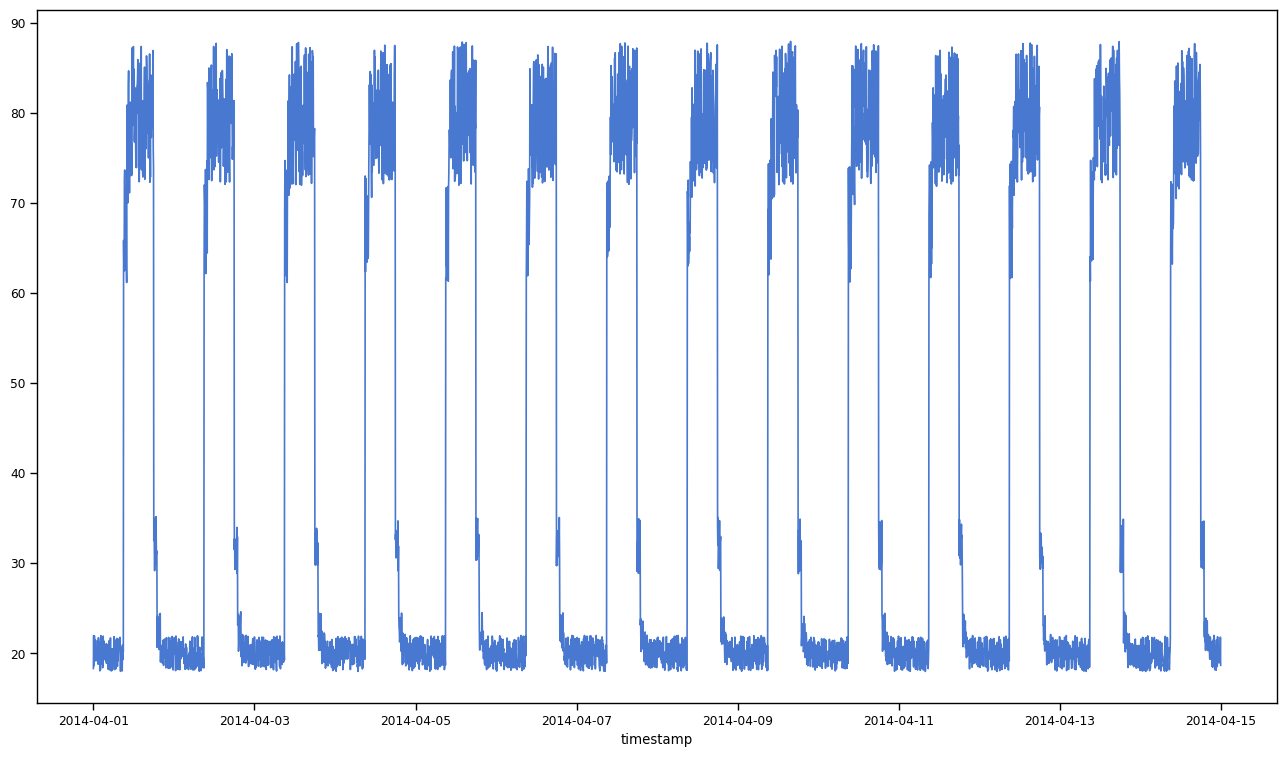

In [8]:
# Set colour palette
sns.set_palette("muted")
# Set style and figure size
sns.set_context("paper", font_scale=1)
fig, ax = plt.subplots(figsize=(16,9))

# Plot the data
sns.lineplot(data=df_small_noise, legend=False)
plt.show()

### Timeseries data with anomalies

Use the following data for testing and see if the data point that's out of range is detected as an anomaly

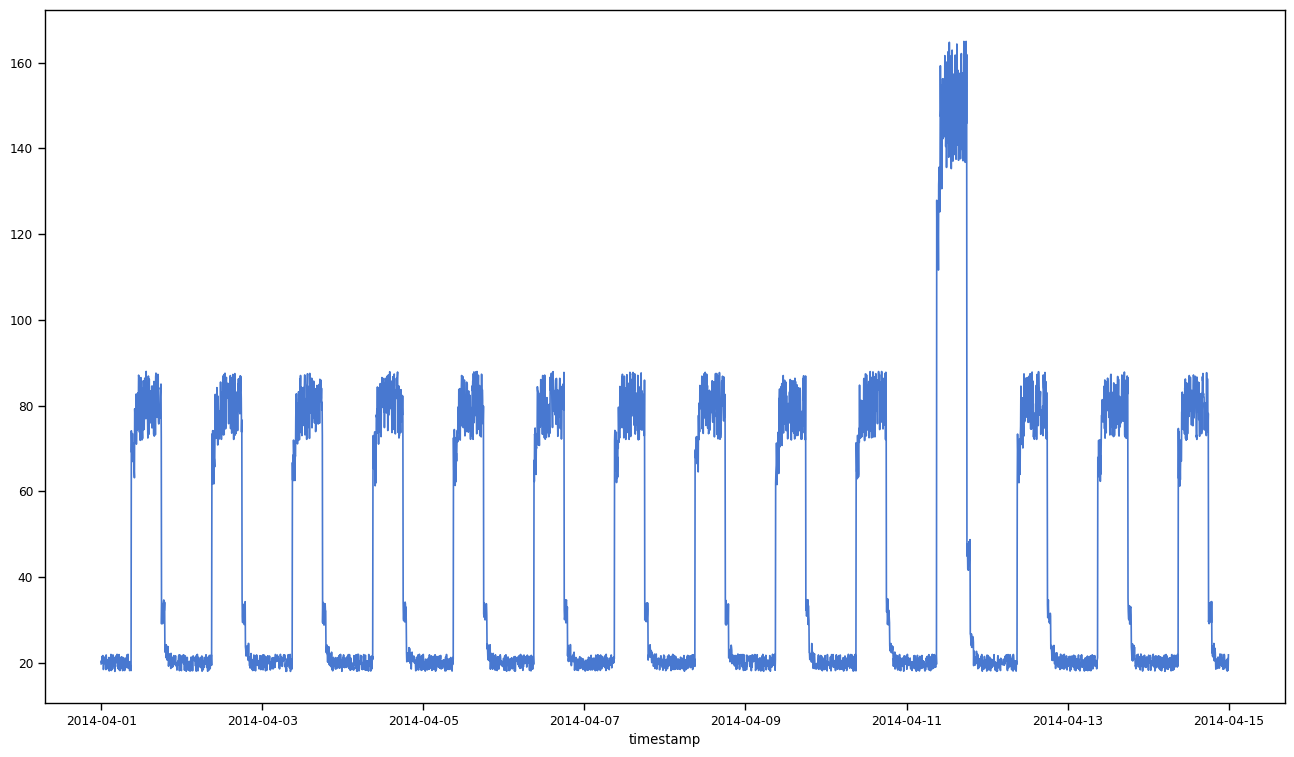

In [9]:
# Set colour palette
sns.set_palette("muted")
# Set style and figure size
sns.set_context("paper", font_scale=1)
fig, ax = plt.subplots(figsize=(16,9))

# Plot the data
sns.lineplot(data=df_daily_jumpsup, legend=False)
plt.show()

So it can be seen that there is indeed an anomaly.<br>
The next stage is to prepare the training data to train the autoencoder.

## Prepare the training data

At this stage, the data has to be prepared so that the model can 'learn' from it and detect anomalies.<br>
This is also known as preprocessing.<br>

Preprocessing is the stage where the data is checked and in the format that is needed to train and produce machine learning models.<br>
The very first stages were done in the previous section where the the number of rows in each data file were checked to make sure that there was no missing values.<br>

First, the data has to be normalized before anything else is done.<br>
Normalizing the data changes the data to a common scale without changing the differences in the range of values.

Get data values from the training timeseries data, *normalize* the value data.<br>
The value data points are every 5 minutes for 14 days.
- 24 * 60 / 5 = **288 timesteps per day**
- 288 * 14 = **4032 total data points**

### Preprocessing

In [10]:
# Normalize and save the mean and std we get,
# for normalizing test data.

# Get the mean and std deviation of training data
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

# Normalise
df_training_value = (df_small_noise - training_mean) / training_std

# Confirm that the number of samples are the same.
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Mean and standard deviation

In [11]:
print(f'The mean of the training values is: {training_mean}')
print(f'The standard deviation of the training values is: {training_std}')

The mean of the training values is: value    42.438353
dtype: float64
The standard deviation of the training values is: value    28.077122
dtype: float64


The above can be rewritten as below to add columns to the dataframe with:<br>
- original value - mean
- original value / standard deviation

This will allow the columns to be plotted if desired.

### Add preprocessed data to dataframe

In [12]:
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


Plot the normalised training value below - Note the reduction in amplitude of the timeseries signal. 

### Plot normalised training value

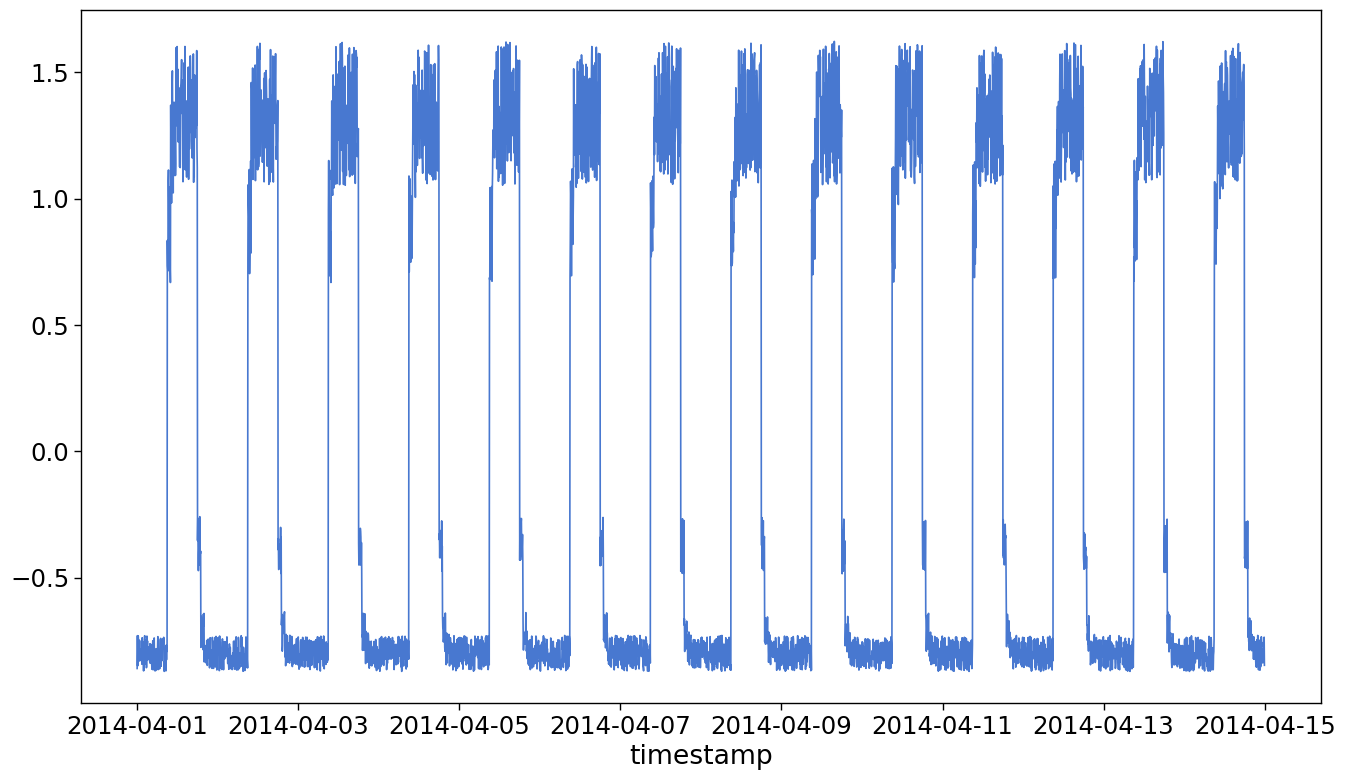

In [13]:
sns.set_palette("muted")
sns.set_context("paper", font_scale=2)

plt.figure(figsize=(16,9))
sns.lineplot(data=df_training_value, label='training value', legend=False)
plt.show()

In [14]:
# Check that the shape of the training value is consistent with the rest of the data.
df_training_value.shape

(4032, 1)

In [15]:
# Get the mean of each column
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [16]:
# Get the standard deviation of each column
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

Plot the new columns below to confirm whether the normalisation. Compare with original data.

### Plot training data vs normalised data

<AxesSubplot:xlabel='timestamp', ylabel='value'>

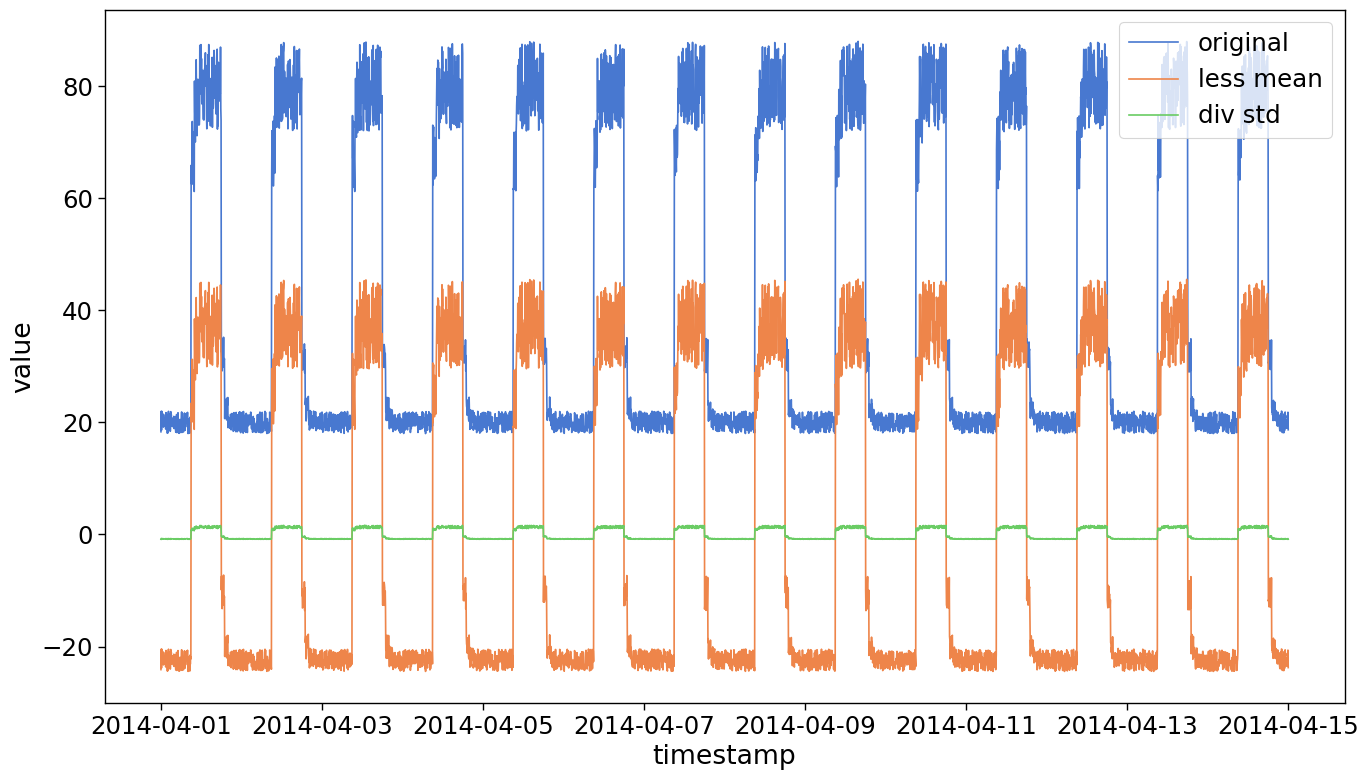

In [17]:
sns.set_palette("muted")
sns.set_context("paper", font_scale=2)
plt.figure(figsize=(16,9))

sns.lineplot(data=df_small_noise['value'], label='original')
sns.lineplot(data=df_small_noise['less_mean'], label='less mean')
sns.lineplot(data=df_small_noise['div_std'], label='div std')
#plt.show()

So all the orginal information is still there - just in a much smaller range.

## Create sequences

In order for the model to learn, a 'window' has to be created in order to 'look' at the data.
The window is just a sample size for the autoencoder to analyse the training data and learn from.



### Example of window size

Window example:

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
```

So from the above, it can be see that with an array of length 12 and a window size of 3, it will take 4 passes to get to the end: 12/3 = 4.<br>

Similarly, from 4032 data points:<br>
4032/288 = 14

Note that the Keras example uses a window size of 288 and that's what will be stuck to for now.

### Number of windows needed

In the following example, the relationship between the window size and input array will be explored.

In [18]:
# Window list example.
window_example = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Window size for above example
w_size = 3

# Length of array
len(window_example)

12

In [19]:
# Number of windows from L.
len(window_example) - (w_size - 1)

10

In [20]:
# Answer is the same because of -- being +
len(window_example) - w_size + 1

10

In [21]:
# For accumulating the windows in the above example
wins = []
# Generate the windows.
# From i up till i + window size
for i in range(len(window_example) - w_size + 1):
    #print(L[i:i + win_size])
    wins.append(window_example[i:i + w_size])

print(f'input array: {window_example}')
print('Windows needed for example:')
print(wins)
print(f'Length of output array containing the windows: {len(wins)}')

input array: [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
Windows needed for example:
[[1, 1, 2], [1, 2, 4], [2, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 1], [7, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5]]
Length of output array containing the windows: 10


In [22]:
# Create a 2D numpy array from the output 
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

So for the Keras example with window size of 288, using the process of the example above,<br>
The input shape has the following length:

In [23]:
# Length of input data file
len(df_small_noise) - 288 + 1

3745

Below is the input data, ending up with a training shape.<br>
Note the calculation is just like the above, with the output being converted to a numpy 2D array.<br>
The code is put into a function so that it can be re-used.

### The Keras website example

In [24]:
window_size = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=window_size):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# Create sequences for the values in the dataframe
x_train = create_sequences(df_training_value.values)

# Print the output shape: (4032 - 287)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


Now look at the output: Note how each value is wrapped in a 1-element list.

In [25]:
print(x_train)

[[[-0.85882857]
  [-0.72899302]
  [-0.84814772]
  ...
  [-0.86453747]
  [-0.81250829]
  [-0.79671155]]

 [[-0.72899302]
  [-0.84814772]
  [-0.72958579]
  ...
  [-0.81250829]
  [-0.79671155]
  [-0.78767946]]

 [[-0.84814772]
  [-0.72958579]
  [-0.731173  ]
  ...
  [-0.79671155]
  [-0.78767946]
  [-0.73706287]]

 ...

 [[-0.8226548 ]
  [-0.86660975]
  [-0.82181363]
  ...
  [-0.79164661]
  [-0.78025492]
  [-0.83364049]]

 [[-0.86660975]
  [-0.82181363]
  [-0.75595835]
  ...
  [-0.78025492]
  [-0.83364049]
  [-0.73510213]]

 [[-0.82181363]
  [-0.75595835]
  [-0.74256753]
  ...
  [-0.83364049]
  [-0.73510213]
  [-0.8460886 ]]]


### Superimposing the window on top of the data

The window can be plotted with the data to get an understanding of how it 'slides along' the data.<br>
Below is a plot of the window up to 1200 values.

''

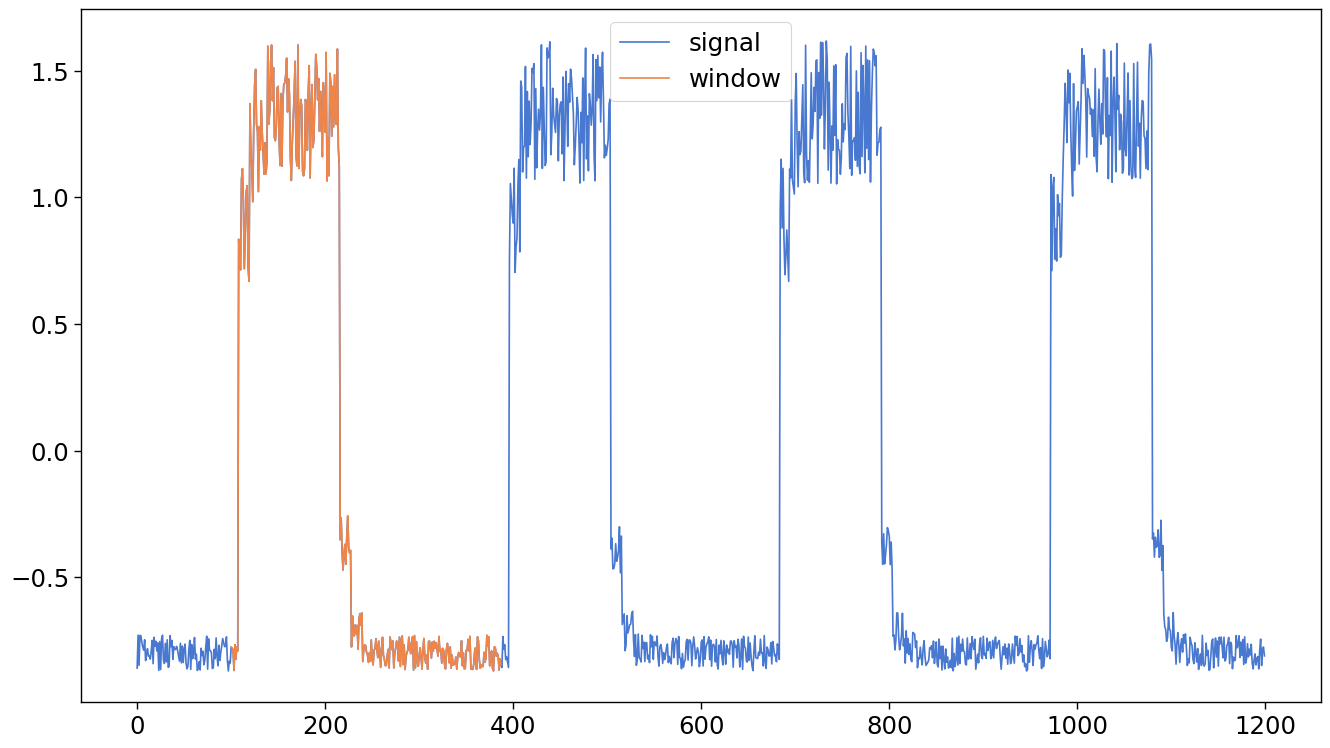

In [26]:
# Number of values to look at
window_no = 100

# Set the plot size
fig, ax = plt.subplots(figsize=(16, 9))

# Pull the y values of the train_vals datafram
#y = df_train_vals['value'].values
# Could even just look at the first 100 or more values, in this case, 1200
# Can get rid of the [:1200] below to get more of the data
y = df_training_value['value'].values[:1200]

# The arange is a trick to show the data points on the x-axis, all the way up to 4031
ax.plot(np.arange(y.shape[0]), y, label='signal')

# Plot the first window on top
w = x_train[window_no].flatten()

# Plot w as well
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend()
# What's plotted in orange is actually the window itself.
;

Note how in the plot below, the window is sliding along the data.

''

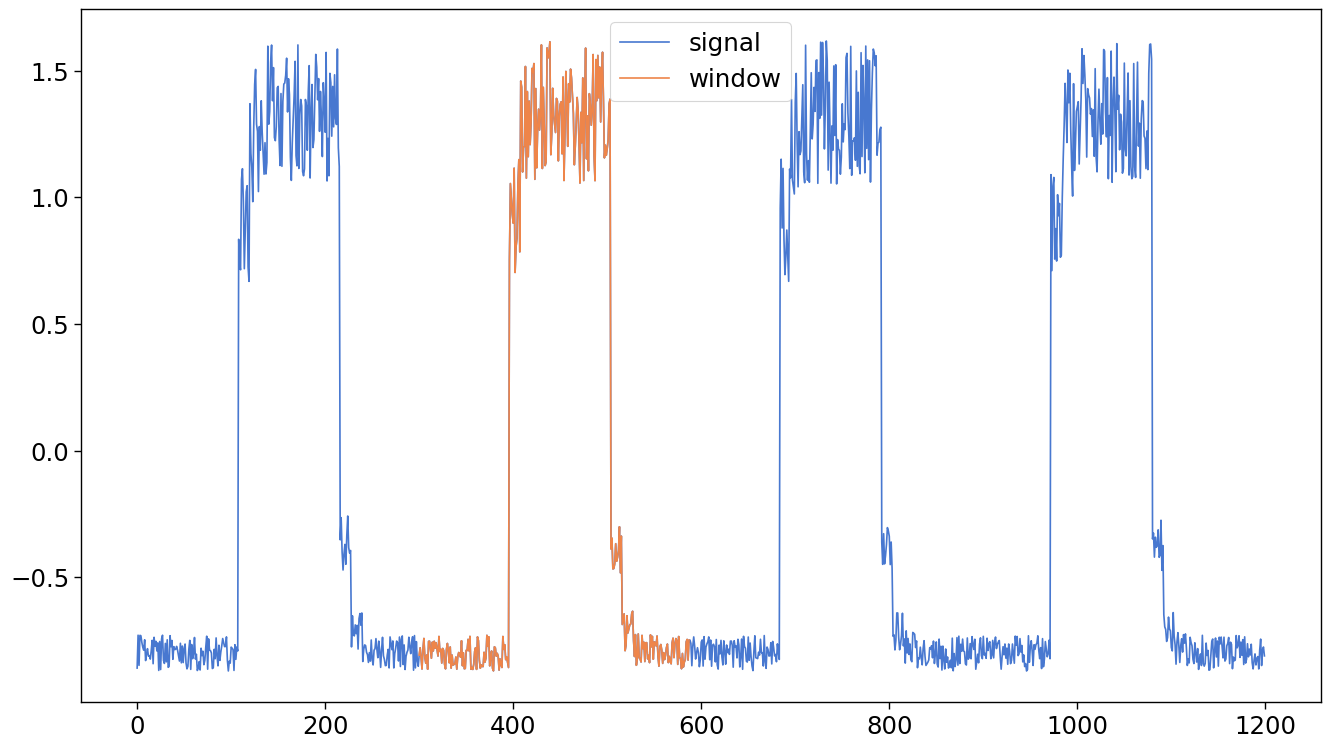

In [27]:
# Number of values to look at
window_no = 300

# Set the plot size
fig, ax = plt.subplots(figsize=(16, 9))

y = df_training_value['value'].values[:1200]

# The arange is a trick to show the data points on the x-axis, all the way up to 4031
ax.plot(np.arange(y.shape[0]), y, label='signal')

# Plot the first window on top
w = x_train[window_no].flatten()

# Plot w as well
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend()
# What's plotted in orange is actually the window itself.
;

## Neural network

Although you can have multi-dimensional inputs in Keras, in this case, there's a 1d as input. All the values in the window are going into the neural network. That means that there's 288 nodes (or neurons) with 288 values, each of which is an input from the dataset.

### Build a model


The next step is to build a model - the convolutional reconstruction autoencoder model.<br>
The model will take input of shape:<br>
**batch_size<br>
sequence_length<br>
num_features**<br>
and return an output of the same shape.

From the created sequence above:<br>
*sequence_length* = 288<br>
and *num_features* = 1<br>

Note how the sequence length is the same as the window size.

### Code Explanation of example

The following section will look the code used in the example and explain what each piece does and why it's there.<br>

### Convolution and convolutional layer

Convolution is a linear operation that involves multiplying weights with the input and producing an output.
This multiplication is performed between the input (which is an array) and an array of weights called a kernel (also known as a filter).<br>

[Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/) is a 1-dimensional convolutional layer.<br>
The Keras documentation states that a Conv1D layer is used for dealing with time series data.

A convolutional layer is another way of saying 'A window that slides over the data we have'.

In this case, because it's time series data, the window is sliding along in one dimension (time).

In a 2-dimensional convolutional layer ([Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)), the window is sliding along 2 dimensions, x and y.<br>

The deconvolution layers are mirror opposites of the convolution layers.

The convolution and deconvolution layers have activation functions specified as "relu".
This is the [rectified linear activation function (ReLu)](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/). It outputs the input directly if it's positive, otherwise it outputs 0.<br>
It's become the default activation function for neural networks because it's easier to train and produces a model with better performance.

### The sequential model

Below a Sequential model is created using [keras.Sequential](https://keras.io/guides/sequential_model/).<br>
It's used for training the neural network in order to create a model.<br>

The Sequential model is also known as the Sequential API - it lets the user create a model layer by layer, as needed.<br>
Note that the first layer in the Sequential model needs to receive information about it's input shape and is [specified as a tuple](https://faroit.com/keras-docs/1.2.0/getting-started/sequential-model-guide/).<br>
[keras.layers.Input](https://keras.io/api/layers/core_layers/input/) in the Keras documentation lists all the parameters that can be specified at the input layer.<br>


To recap, *x_train* was the original data in a much smaller range.

**Step 1:**<br>
The size and sequence length of *x_train* are passed in as parameters to the input layer, before being passed to the convolutional layer.<br>

**Step 2:**<br>
Because we're dealing with time series (one dimension), a *1-Dimensional convolution layer* (Conv1D) is convolved with the input layer.<br>
This is known as the *convolutional layer* - note that in a convolutional neural network, the first layer (after the input) is always a convolutional layer.

**Step 3:**<br>
After the convolutional layer, the next layer is the *Dropout layer*.<br>
Droput is a technique used to prevent a model from overfitting; it works by randomly sets input units to 0 with a frequency of *rate* at each step during the training time.<br>
Inputs not set to 0 are scaled up by<br>
$\frac{1}{1 - rate}$<br>
so that the sum over all inputs is unchanged.<br>
Note that *rate* is a float between 0 and 1 and represents a fraction of the input units to drop.<br>
If a dropout layer wasn't used, the first batch of training samples would have a large influence on the learning and other features might be missed.<br>

**Step 4:**<br>
Deconvolution layer (Transpose convolution).<br>
This reverses the convolution by dimensions only, not by values.
Looking at the code below, the transposed convolution (deconvolution) takes the output of the convolution layer as it's input and the deconvolution layer returns the original data as it's output.

**Step 5:**<br>
Dropout layer - the dropout layer is identical to the one in step 3.<br>

**Step 6:**<br>
Deconvolution layer - This one mirrors the convolution layer at step 2 with 32 filters.

**Step 7:**<br>
Deconvolution layer (final one) - to get the 

Note the filter sizes in the code and the pattern:<br>
- Convolution layer with filter size of 32
- Convolution layer with filter size of 16
- Deconvolution layer with filter size of 16
- Deconvolution layer with filter size of 32

### Model Compilation

[Stochastic Gradient Descent](https://optimization.cbe.cornell.edu/index.php?title=Stochastic_gradient_descent) is an optimization algorithm often used in machine learning or deep learning to find the model parameters corresponding to the best fit between predicted and actual outputs.
It has a learning rate (a small postive value) that doesn't change during training.

Stochastic gradient descent is usually combined with backpropagation, it’s typically found in neural network training applications.

[Adam](https://keras.io/api/optimizers/adam/) is an optimizer in Keras.<br>
It's not an acronym, but the name is derived from **Ada**ptive estimation of first-order and second-order **M**oments.<br>
One of it's arguments is *learning rate* which defaults to 0.001.<br>
Adam is [one of the optimizers](https://keras.io/api/optimizers/) that are used for compiling a model in Keras.
The optimizer is typically placed inside model.compile(), as in the below code example.
Adam was designed to combine the advantages of two other algorithms:
- [Adaptive Gradient Algorithm (AdaGrad)](https://machinelearningmastery.com/gradient-descent-with-adagrad-from-scratch/)<br>
- [Root Mean Square Propagation (RMSProp)](https://www.andreaperlato.com/aipost/root-mean-square-propagation/)<br>

Adagrad adapts a learning rate for each parameter and is best for problems with sparse gradients (i.e. computer vision).<br>
RMSProp also adapts a learning rate for each parameter, where the learning rate is adapted based on how quickly the gradient is changing - it's best suited to noisy problems.

**Learning rate** is how large (or small) the step down the gradient is. if the learning rate is too small, the algorithm might converge slowly; if the learning rate is too large, it could make the algorithm divergent.

**loss** is a loss function - to be specific, it's a regression loss function and "mse" stands for Mean Squared Error.<br>
It's the default loss function for regression.<br>
Mean Squared Error is calculated as the average of the squared differences between the predicted and actual values.<br>
Because of the squaring, the result is always positive; a perfect value for mean squared error is 0.0.<br>
The squaring also means that larger mistakes correspond with larger error than smaller mistakes - so the model is penalised for making large mistakes.

In [28]:
# Reminder of the training data
x_train.shape

(3745, 288, 1)

## Code for the Sequential model

In [29]:
# Create a Sequential model
model = keras.Sequential(
    [
        # Define the input shape
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        # 2nd layer - Convolutional layer
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 3rd layer - Dropout layer
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 4th layer - Deconvolution layer
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 5th layer - Dropout layer
        layers.Dropout(rate=0.2),
        # 6th layer - Deconvolution layer
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 7th layer - Deconvolution layer
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

### Model weights

In [30]:
# These are the weights of the neurons
model.get_weights()

[array([[[-0.05486542, -0.1237065 ,  0.11895271, -0.05044544,
           0.07264976, -0.12626949, -0.08467687,  0.04973954,
           0.1226768 , -0.05835545,  0.00463554,  0.11887051,
           0.06190939, -0.05591376, -0.06553452, -0.06573571,
          -0.13388933, -0.08088478,  0.06218605,  0.07566033,
           0.12157224, -0.11259571, -0.0966436 ,  0.11063208,
           0.1394005 , -0.10842794,  0.02675588,  0.08338304,
          -0.00741346, -0.01210333, -0.04477327,  0.0975333 ]],
 
        [[-0.1424476 , -0.11055513,  0.08315551,  0.06220172,
          -0.00497054, -0.09371684,  0.04120466,  0.11173473,
          -0.06144195, -0.12053697,  0.00690521,  0.07583264,
          -0.15861389,  0.11060424, -0.04327444,  0.00342236,
           0.01392359, -0.08482838,  0.12896426,  0.08230014,
           0.01945955, -0.11032881, -0.05555856, -0.14547256,
          -0.06067649,  0.02764714,  0.03300583, -0.03336307,
          -0.08019471, -0.00655678, -0.06562501, -0.05783465]],
 


## Train the model

Because this is a reconstruction model, *x_train* will be used as both the input and target.

In [31]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 25ms/step - loss: 0.4437 - val_loss: 0.0921
Epoch 2/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0762 - val_loss: 0.0418
Epoch 3/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0560 - val_loss: 0.0341
Epoch 4/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0467 - val_loss: 0.0311
Epoch 5/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0411 - val_loss: 0.0273
Epoch 6/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0370 - val_loss: 0.0244
Epoch 7/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0336 - val_loss: 0.0222
Epoch 8/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0309 - val_loss: 0.0211
Epoch 9/50
27/27 [==============================] - 0s 18ms/step - loss: 0.0289 - val_loss: 0.0195
Epoch 10/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0273 - val_loss: 0.0203
Epoch 11/

### Epoch Definition

From the results above, the phrase *Epoch* is used.

Machine learning models are trained by passing datasets through algorithms.
The phrase *Epoch* is used to describe an entire dataset being passed through an algorithm once.

An Epoch is also known as a *hyperparameter*.

### Training and validation loss

Now plot the training and validation loss to check the training:

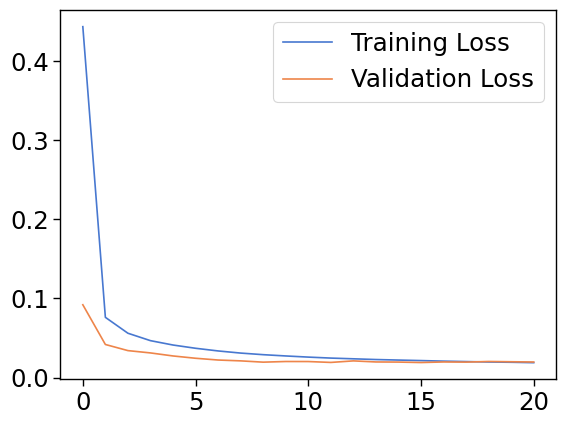

In [32]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Now create two more models with different dropout rates to see the effect on training and validation loss.

### Second model

In [61]:
# Create a Sequential model
model2 = keras.Sequential(
    [
        # Define the input shape
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        # 2nd layer - Convolutional layer
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 3rd layer - Dropout layer
        layers.Dropout(rate=0.1),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 4th layer - Deconvolution layer
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 5th layer - Dropout layer
        layers.Dropout(rate=0.1),
        # 6th layer - Deconvolution layer
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 7th layer - Deconvolution layer
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_14 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_21 (Conv1D  (None, 144, 16)          1808      
 Transpose)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 144, 16)           0         
                                                                 
 conv1d_transpose_22 (Conv1D  (None, 288, 32)          3616      
 Transpose)                                           

In [62]:
history2 = model2.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 24ms/step - loss: 0.5119 - val_loss: 0.0494
Epoch 2/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0674 - val_loss: 0.0429
Epoch 3/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0496 - val_loss: 0.0353
Epoch 4/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0427 - val_loss: 0.0305
Epoch 5/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0369 - val_loss: 0.0257
Epoch 6/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0311 - val_loss: 0.0211
Epoch 7/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0184
Epoch 8/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0240 - val_loss: 0.0170
Epoch 9/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0221 - val_loss: 0.0162
Epoch 10/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0206 - val_loss: 0.0156
Epoch 11/

### Third model

In [55]:
# 3rd model

In [59]:
# Create a Sequential model
model3 = keras.Sequential(
    [
        # Define the input shape
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        # 2nd layer - Convolutional layer
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 3rd layer - Dropout layer
        layers.Dropout(rate=0.4),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 4th layer - Deconvolution layer
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 5th layer - Dropout layer
        layers.Dropout(rate=0.4),
        # 6th layer - Deconvolution layer
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # 7th layer - Deconvolution layer
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_12 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 144, 16)          1808      
 Transpose)                                                      
                                                                 
 dropout_13 (Dropout)        (None, 144, 16)           0         
                                                                 
 conv1d_transpose_19 (Conv1D  (None, 288, 32)          3616      
 Transpose)                                           

In [60]:
history3 = model3.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 27ms/step - loss: 0.6864 - val_loss: 0.1937
Epoch 2/50
27/27 [==============================] - 0s 15ms/step - loss: 0.1239 - val_loss: 0.0446
Epoch 3/50
27/27 [==============================] - 1s 20ms/step - loss: 0.0796 - val_loss: 0.0426
Epoch 4/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0672 - val_loss: 0.0433
Epoch 5/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0601 - val_loss: 0.0420
Epoch 6/50
27/27 [==============================] - 1s 21ms/step - loss: 0.0550 - val_loss: 0.0409
Epoch 7/50
27/27 [==============================] - 1s 20ms/step - loss: 0.0503 - val_loss: 0.0409
Epoch 8/50
27/27 [==============================] - 1s 20ms/step - loss: 0.0469 - val_loss: 0.0421
Epoch 9/50
27/27 [==============================] - 0s 18ms/step - loss: 0.0440 - val_loss: 0.0452
Epoch 10/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0414 - val_loss: 0.0492
Epoch 11/

### Losses compared

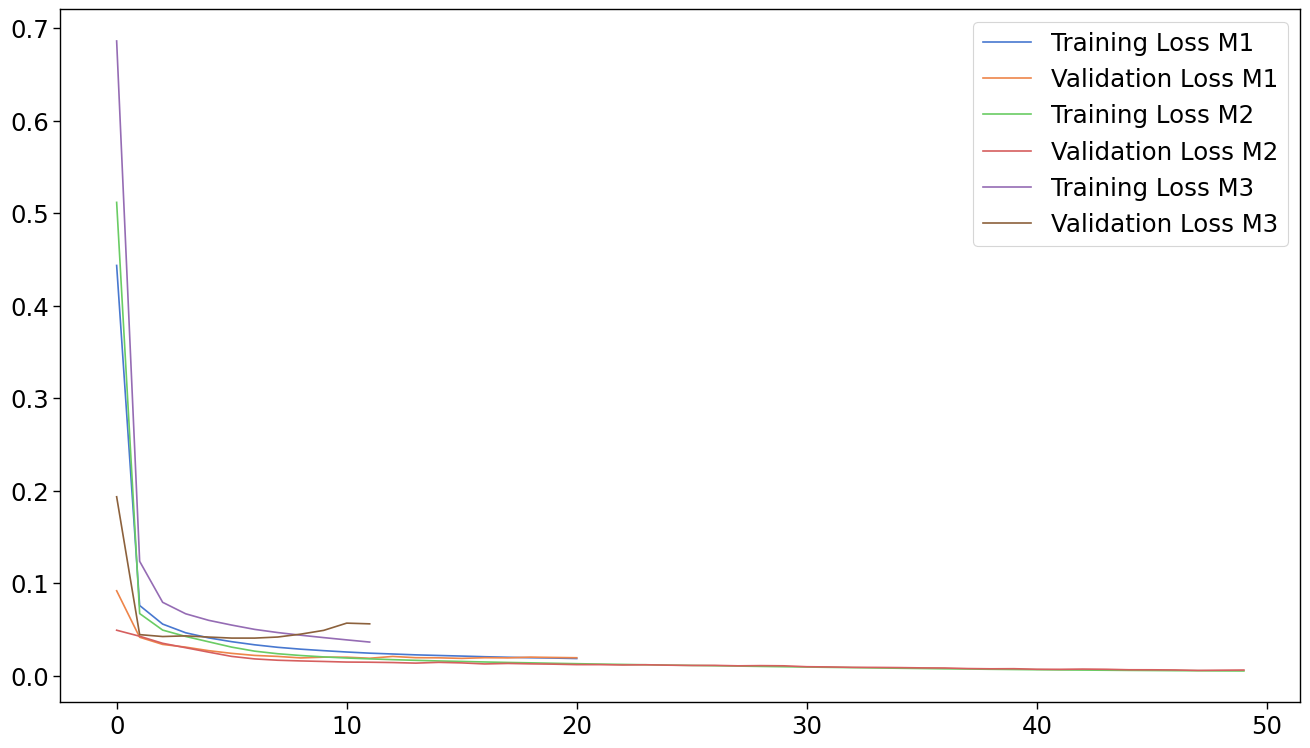

In [66]:
fig, ax = plt.subplots(figsize=(16,9))
sns.color_palette("magma")
sns.lineplot(history.history["loss"], label="Training Loss M1")
sns.lineplot(history.history["val_loss"], label="Validation Loss M1")
sns.lineplot(history2.history["loss"], label="Training Loss M2")
sns.lineplot(history2.history["val_loss"], label="Validation Loss M2")
sns.lineplot(history3.history["loss"], label="Training Loss M3")
sns.lineplot(history3.history["val_loss"], label="Validation Loss M3")
plt.legend()
plt.show()

## Anomaly detection

Now find the anomalies by using the model to reconstruct the input data.<br>
The maximum MAE loss value will be the threshold for anomaly detection as it's the lowest performance the model has achieved whilst attempting to reconstruct a sample.<br>

The *Mean Absolute Error*, or MAE, is the loss function chosen in this case because it's more resistant to the effect of outliers on the overall performance.<br>
It's calculated as the average of the absolute difference between actual and predicted values.

The following steps can be taken for detecting anomalies:
1. Find MAE (Mean Absolute Error) loss on training samples.
2. Find the maximum MAE loss value - this will be the *threshold* value.
3. If the reconstruction loss for a data sample is greater than the *threshold* value, it can be inferred that the model is observing an unfamiliar pattern - this will be labelled as an *anomaly*.

In [ ]:
# Get training MAE loss for all the models

# 1st model
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# 2nd model
x_train_pred2 = model2.predict(x_train)
train_mae_loss2 = np.mean(np.abs(x_train_pred2 - x_train), axis=1)

# 3rd model
x_train_pred3 = model3.predict(x_train)
train_mae_loss3 = np.mean(np.abs(x_train_pred3 - x_train), axis=1)

In [85]:
#plt.figure(figsize=(20, 7))
#plt.hist(train_mae_loss, bins=50)
#plt.xlabel("Train MAE loss")
#plt.ylabel("No of samples")
#plt.show()

# Get reconstruction loss threshold.
threshold1 = np.max(train_mae_loss)
threshold2 = np.max(train_mae_loss2)
threshold3 = np.max(train_mae_loss3)
print("Reconstruction error threshold for 1st model: ", threshold1)
print("Reconstruction error threshold for 2nd model: ", threshold2)
print("Reconstruction error threshold for 3rd model: ", threshold3)

Reconstruction error threshold for 1st model:  0.11321697875916037
Reconstruction error threshold for 2nd model:  0.07656450838459333
Reconstruction error threshold for 3rd model:  0.22914943829168008


It can be seen that a lower dropout rate produces a lower error threshold.

In [72]:
# Put training losses in an array
model_training_losses = [train_mae_loss, train_mae_loss2, train_mae_loss3]

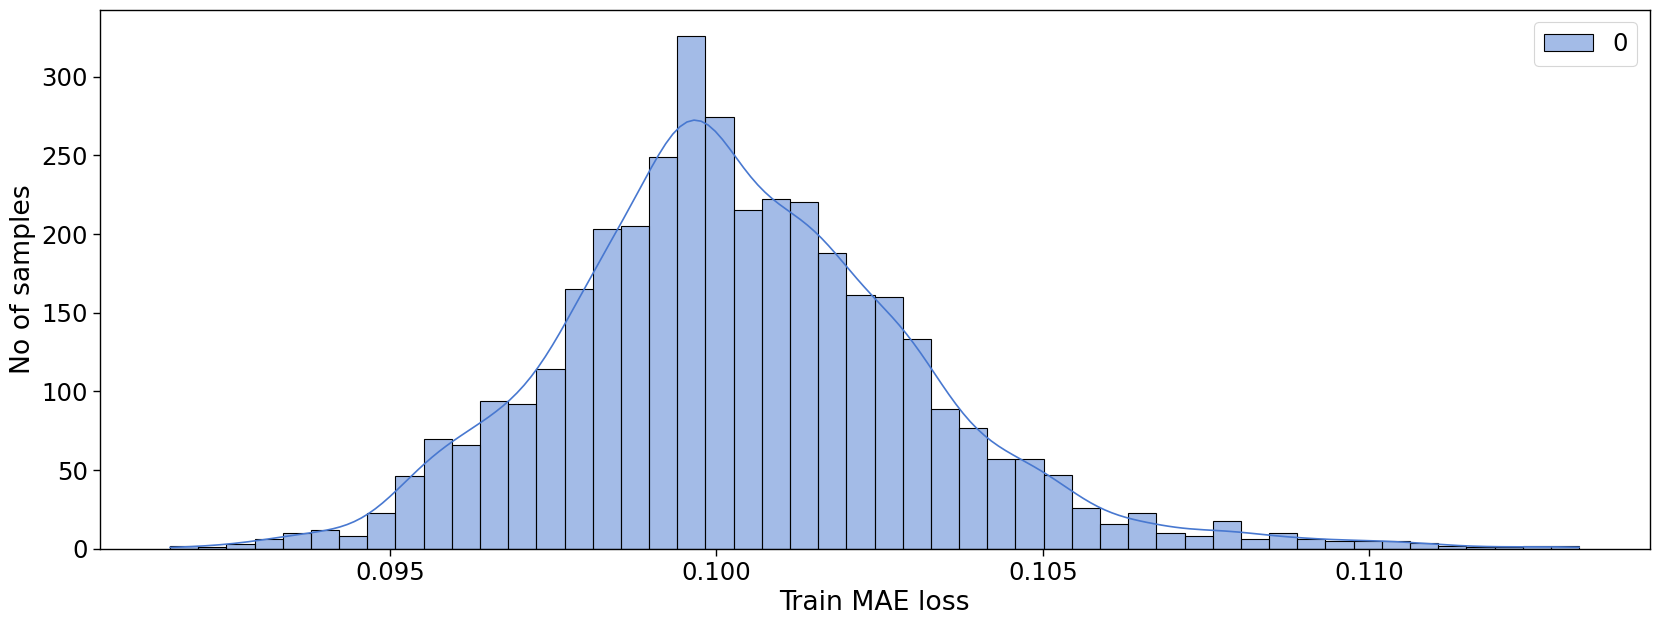

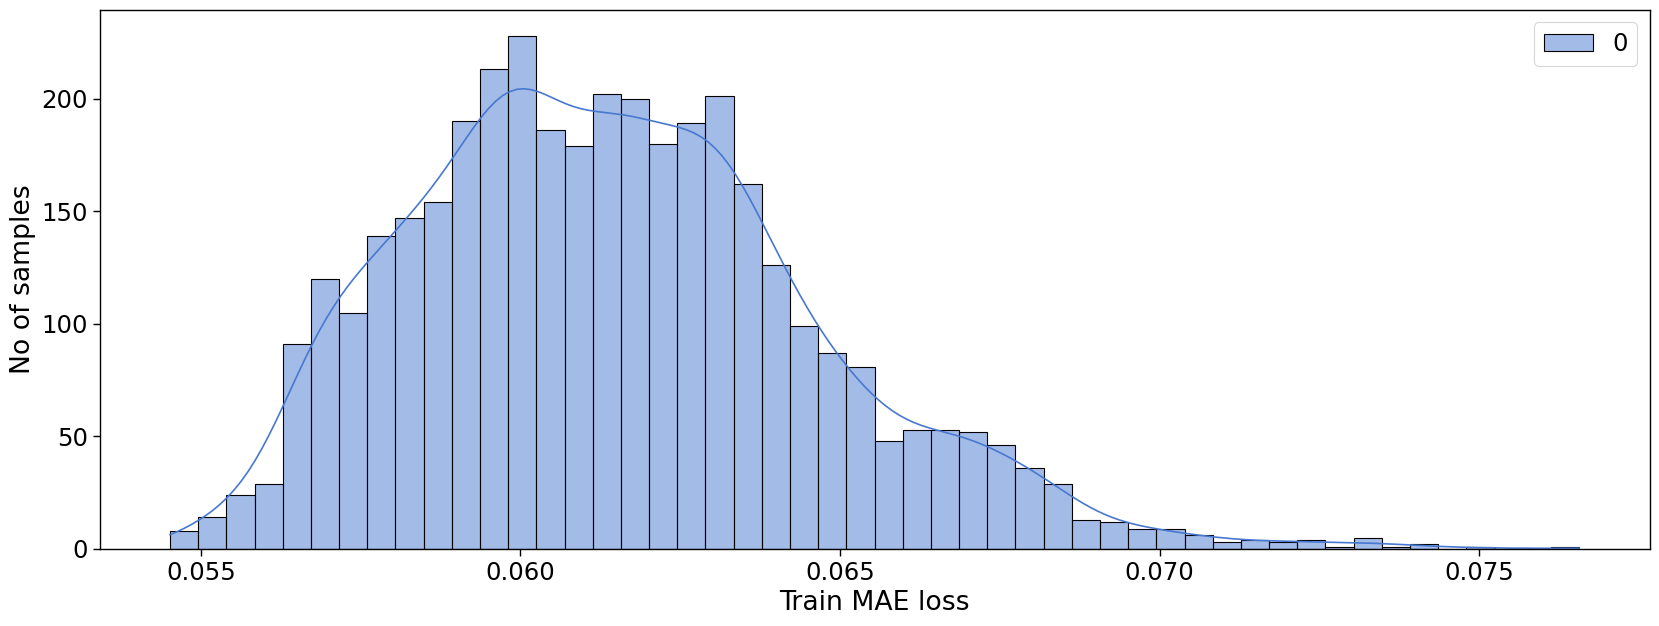

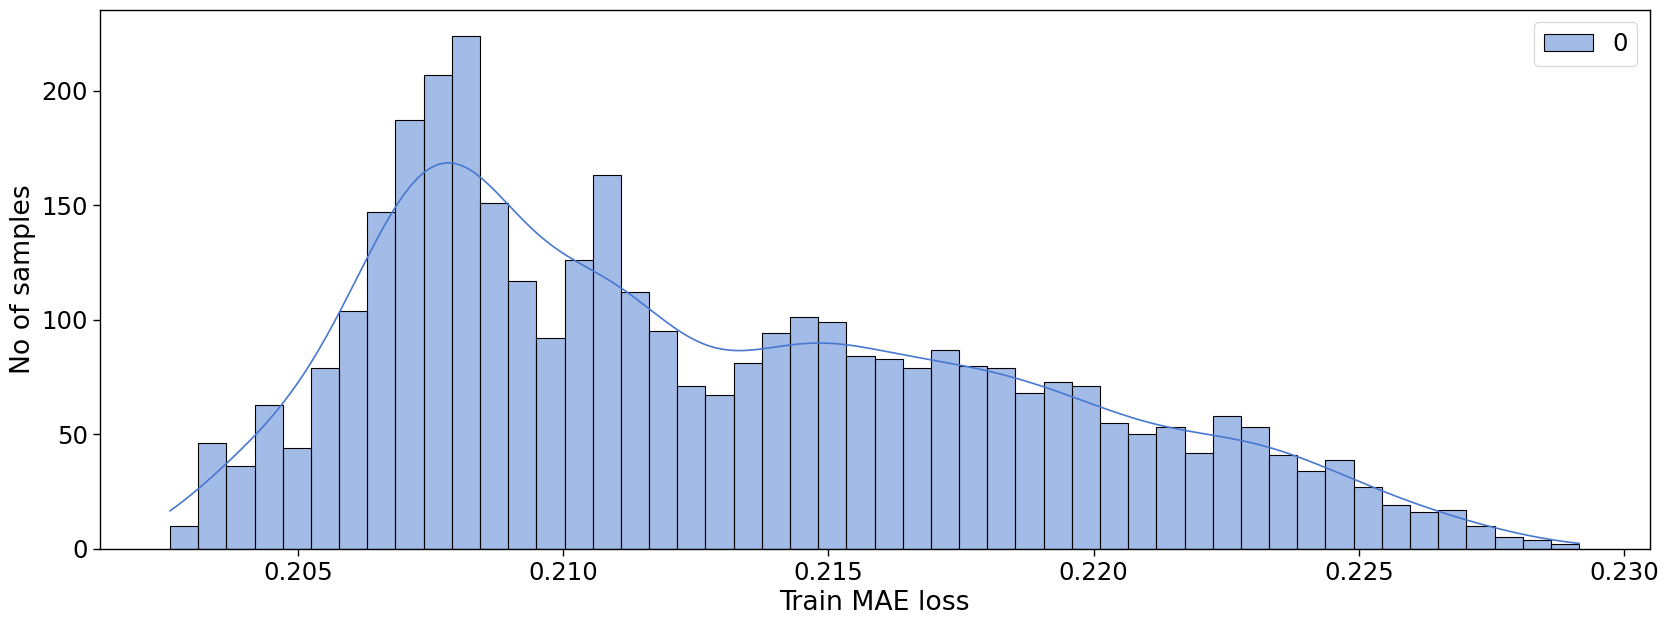

In [83]:
for variable in model_training_losses: 
    sns.set_context("paper", font_scale=2)
    plt.figure(figsize=(20, 7))
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    sns.histplot(variable, bins=50, kde=True)

### Compare reconstructed data with training data

We can compare the data sample that the model has generated for the first day with the training data for the first day - this is 288 timesteps

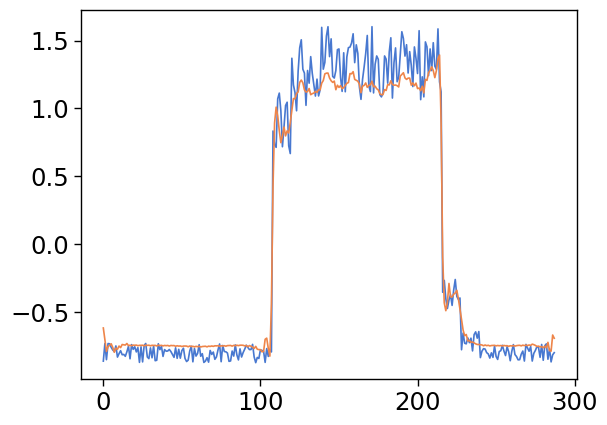

In [34]:
# Checking the first day's data sample with the original
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data for the model

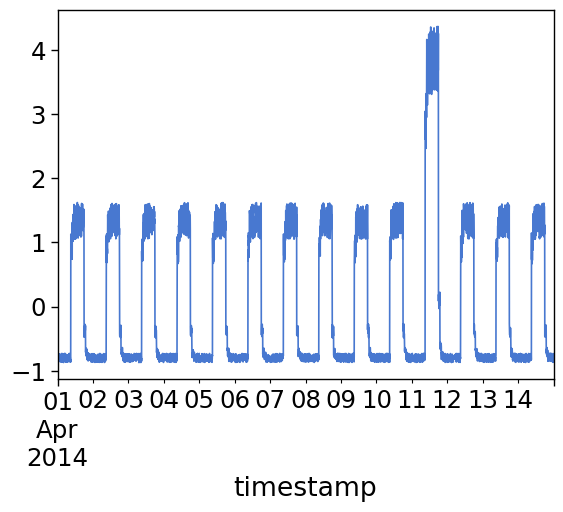

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 0s 2ms/step


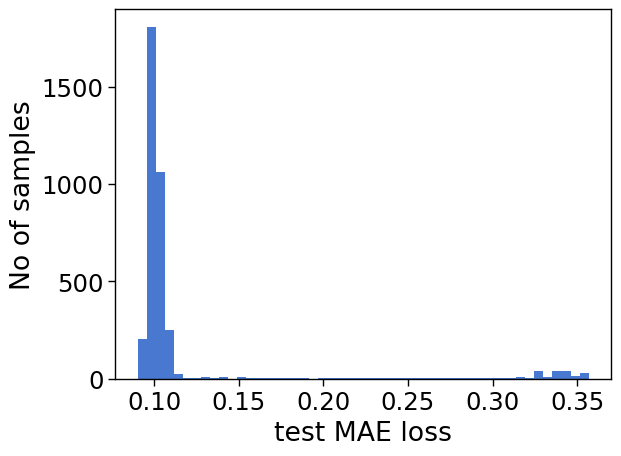

Number of anomaly samples:  406
Indices of anomaly samples:  (array([1652, 1653, 1654, 1655, 1657, 1658, 1659, 2519, 2521, 2522, 2698,
       2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711,
       2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722,
       2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733,
       2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
       2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755,
       2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2

In [35]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

The constructed data has shown us which data samples are anomalies, so we can plot the anomalies by using the corresponding timestamps of the training (original) data.<br>

This is the method:
If window_size = 3 and there's 10 training values, <span style="color:red">x_train</span> will look like:<br>
- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9
<br>

All the values except the initial and the final time step values (window_size - 1) will appear in the time_steps number of samples.<br>
So, if we know that the following samples:<br>

[(3, 4, 5), (4, 5, 6), (5, 6, 7)]<br>

are anomalies, we can say that data point 5 is an anomaly.

In [36]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[data_idx - window_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Overlay the anomalies on the original test plot.

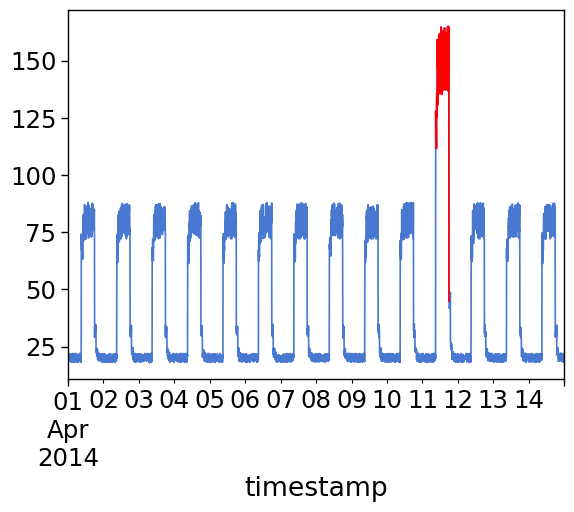

In [37]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

## Conclusion

The notebook started with an introduction to the project and what it was going to be about, namely, recreating the example from the Keras documentation and explaining the concepts in the example in more detail.<br>
It then went on to explain what a time series was and how it was analysed before moving on to anomaly detection.<br>
Types of anomalies were explained, with examples of each type.<br>

Terminology used in deep learning and machine learning was explained, especially with regards to:
- Training loss
- Validation loss
- Mean Absolute Error

This led on to a brief comparison between Tensorflow and Keras, before listing the libraries needed for the project.<br>
Visualisations were done for both data files - without anomalies and with anomalies, to confirm what was found from the basic statistics (very high maximum value in the anomaly data file).<br>

Preprocessing was explained in more detail than the Keras example, with a comparison of the compressed, normalised data with the original data.<br>

Following on from the preprocessing, sequences were created for the model, explaining window size and how it's related to the output shape.<br>
The code from the Keras example was run, and the window was superimposed on top of the input data so that one could see how the window works in practice.<br>

After the preprocessing, the task of building a model came next.<br>
The code from the example was explained, with particular attention to convolution/deconvolution and it's role in developing the model, as well as the sequential model and finally, compilation of the model.<br>
After the code from the example was run and the weights displayed, it was time to train the model.<br>

An additional two models were also defined to see how the dropout rate affected the error threshold and it was shown that a lower dropout rate produces a lower error threshold

There was an explanation of what an Epoch was, as well as the training and validation loss for the model.<br>
Finally, it was time to see whether the model could actually detect any anomalies. It could, with the error being superimposed on a plot of the training data.<br>

This notebook has taken an example where, at the start of the module, everything (to me) was completely strange and incomprehensible, to defining a process for creating a model:

1. Get the data
2. Check if the data is complete and get basic statistics from the data to get a basic understanding
3. Visualise the data
4. Normalise the data and preprocess (dimensionality reduction)
5. Create sequences - specify window size
6. Choose type of neural network: number of layers, type of gradient descent and optimization loss


- Overfitting?<br>
    -Model training error goes down whilst validation error goes up
- Define Epoch

## References

1. [Timeseries anomaly detection from Keras](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)
2. [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab)
3. [Explanation of Time Series from Wikipedia](https://en.wikipedia.org/wiki/Time_series)
4. [Explanation of anomaly detection from IBM developer portal](https://developer.ibm.com/learningpaths/get-started-anomaly-detection-api/what-is-anomaly-detection/)
5. [Contextual anomaly detection](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-014-0011-y)
6. [Explanation of an autoencoder from Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)
7. [IBM's definition of deep learning](https://www.ibm.com/cloud/learn/deep-learning)
8. [Explanation of Normalization from Wikipedia](https://en.wikipedia.org/wiki/Normalization_(statistics)#:~:text=In%20another%20usage%20in%20statistics%2C%20normalization%20refers%20to,gross%20influences%2C%20as%20in%20an%20anomaly%20time%20series.)
9. [Why Data Normalization is necessary for Machine Learning](https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029)
10. [Keras Documentation for 1D Convolutional layer](https://keras.io/api/layers/convolution_layers/convolution1d/)<br>
11. [Introduction to autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder)<br>
12. [Definition of autoencoders from the Deep Learning book](https://www.deeplearningbook.org/contents/autoencoders.html)<br>
13. [Definition of variational autoencoders from wikipedia](https://en.wikipedia.org/wiki/Variational_autoencoder)<br>
14. [Colour styling in Seaborn](https://www.codecademy.com/article/seaborn-design-ii)<br>
15. [Variational autoencoders](https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/)<br>
16. [The Conv1D layer explanation from Keras](https://keras.io/api/layers/convolution_layers/convolution1d/)<br>
17. [The sequential model in Keras](https://keras.io/guides/sequential_model/)<br>
18. [The difference between Keras and Tensorflow](https://www.activestate.com/resources/quick-reads/what-is-a-keras-model/)<br>
19. [Tensorflow](https://www.tensorflow.org)<br>
20. [A more concise explanation of the Sequential model](https://faroit.com/keras-docs/1.2.0/getting-started/sequential-model-guide/)<br>
21. [Keras Input layers (Input Object)](https://keras.io/api/layers/core_layers/input/)<br>
22. [Convolutional Neural Networks Cheatsheet (Stanford)](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)<br>
23. [Dropout layer - Keras documentation](https://keras.io/api/layers/regularization_layers/dropout/)<br>
24. [Why use deconvolution in Deep Learning](https://analyticsindiamag.com/why-use-deconvolution-layers-in-deep-learning/)<br>
25. [What are deconvolution layers](https://www.educative.io/answers/what-are-deconvolution-layers)<br>
26. [Adam optimizer in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)<br>
27. [Adam optimizer in Keras](https://keras.io/api/optimizers/adam/)<br>
28. [Stochastic Gradient Descent (Real Python)](https://realpython.com/gradient-descent-algorithm-python/)<br>
29. [Optimizers in Keras (Keras Documentation)](https://keras.io/api/optimizers/)<br>
30. [Adam optimization algorithm in deep learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)<br>
31. [Adaptive Gradient Algorithm (AdaGrad)](https://machinelearningmastery.com/gradient-descent-with-adagrad-from-scratch/)<br>
32. [An overview of gradient descent algorithms](https://ruder.io/optimizing-gradient-descent/)<br>
33. [Root Mean Square Propagation (RMSProp)](https://www.andreaperlato.com/aipost/root-mean-square-propagation/)<br>
34. [List of loss functions in Keras](https://keras.io/api/losses/)<br>
35. [Regression loss - Mean Squared Error](https://keras.io/api/losses/regression_losses/#mean_squared_error-function)<br>
36. [Common Autoencoder limitations](https://www.techtarget.com/searchenterpriseai/feature/How-to-troubleshoot-8-common-autoencoder-limitations)<br>
37. [Introduction to Autoencoders for deep learning](https://www.simplilearn.com/tutorials/deep-learning-tutorial/what-are-autoencoders-in-deep-learning)<br>
38. [Autoencoders tutorial](https://www.edureka.co/blog/autoencoders-tutorial/)<br>
39. [Types of autoencoders and applications](https://fingerprints.digital/en/autoencoder-deep-learning-swiss-army-knife/)<br>
40. [Loss functions in neural networks](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)<br>